# Convert EMAS data to Event Log Data

Now we have acquired our fake artifcial job cycle data by runnng the fake data geneartor notebook we can start to restructure it into an event log format. AN vent log has three key columns. These are a case id llowing you follow a individual cases through a process, an activity or a event column which are the names of the activities/events that the case went trough and finally the timestamp for wene thse activties happened to the case. Other data items may be of iterest in the origianal data, we refre to tehse as case or event attributes and we can include these in the final event log.

This step of extracting the data and turning it into an event log represents the extraction step in the PM$^2$ framework <sup>[1]</sup>.

[1]Van Eck, M. L., Lu, X., Leemans, S. J. & Van Der Aalst, W. M. (2015), Pm: a process mining project
methodology, in ‘International conference on advanced information systems engineering’, Springer, pp. 297–
313.

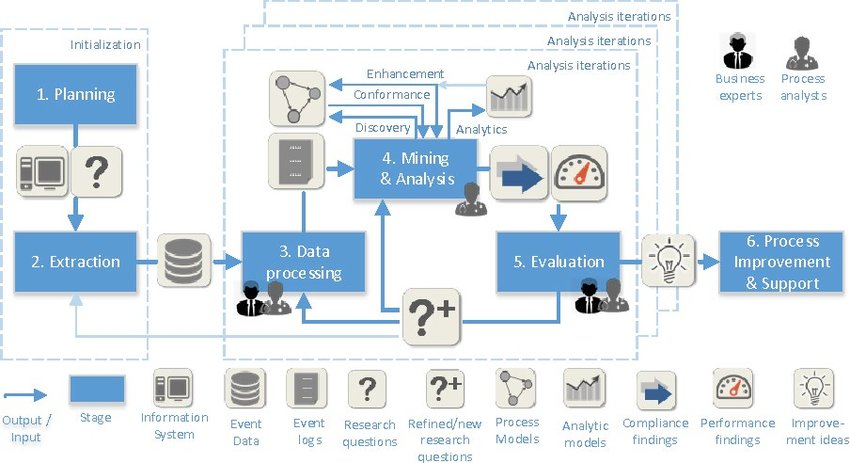

In [1]:
from IPython.display import Image, display
display(Image(filename='PM2_Process-Mining-Project-Methodology.png'))

In python we import open source packages with useful functions that will facillitate our programming

In [2]:
import pandas as pd
import re
import numpy as np

import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import urllib.request
import zipfile

First we need to read in our dataframe of fake data

In [3]:
#df=pd.read_csv('C:/Users/alexander.cole/OneDrive - East Midlands Ambulance Service/Documents',encoding='latin1')
df=pd.read_csv('CAD_data_df.csv')#,encoding='latin1')

It is a good idea to quickly review the datafrae you have read in to chek it resembles the correct file

In [4]:
df.head()

,Unnamed: 0,patientID,Age,Sex,Ethnicity,Incident_Postcode,Clinical Category,Highest Technician on Scene,First NEWS,Last_NEWS,...,Outcome,Incident_Time,Originated,Mobile,Arrive_scene,First_NEWS_Time,LAST_NEWS_Time,Depart_scene,Arrive_dest,Care_transfer
0,0,1,32,Female,White,NN1,Cardiovascular,Paramedic,15,16,...,Alt Transport,2033-03-22 09:22:43.516168,2033-03-22 10:45:43.516168,2033-03-22 11:08:43.516168,2033-03-22 11:38:43.516168,2033-03-22 13:36:43.516168,2033-03-22 14:33:43.516168,2033-03-22 12:18:43.516168,2033-03-22 12:55:43.516168,2033-03-22 12:52:43.516168
1,1,2,78,Male,White,NG3,Cardiovascular,ECP,14,18,...,Treated & Transported,2032-08-10 03:05:39.176702,2032-08-10 05:17:39.176702,2032-08-10 07:54:39.176702,2032-08-10 08:51:39.176702,2032-08-10 08:54:39.176702,2032-08-10 09:39:39.176702,2032-08-10 09:59:39.176702,2032-08-10 10:24:39.176702,2032-08-10 10:26:39.176702
2,2,3,34,Male,White,DN36,Trauma,Paramedic,17,3,...,Treated & Transported,2032-11-09 09:15:24.584089,2032-11-09 11:44:24.584089,2032-11-09 12:21:24.584089,2032-11-09 12:47:24.584089,2032-11-09 14:11:24.584089,2032-11-09 14:45:24.584089,2032-11-09 12:54:24.584089,2032-11-09 13:04:24.584089,2032-11-09 13:07:24.584089
3,3,4,64,Male,White,LN11,Trauma,Paramedic,2,16,...,Alt Transport,2032-10-21 11:19:33.838261,2032-10-21 12:08:33.838261,2032-10-21 12:44:33.838261,2032-10-21 14:11:33.838261,2032-10-21 16:39:33.838261,2032-10-21 17:17:33.838261,2032-10-21 15:34:33.838261,2032-10-21 16:34:33.838261,2032-10-21 16:29:33.838261
4,4,5,62,Female,White,DE7,Respiratory,Paramedic,15,11,...,Treated & Transported,2033-04-26 19:29:16.209876,2033-04-26 22:59:16.209876,2033-04-26 23:41:16.209876,2033-04-27 00:13:16.209876,2033-04-27 02:28:16.209876,2033-04-27 02:28:16.209876,2033-04-27 00:27:16.209876,2033-04-27 00:38:16.209876,2033-04-27 00:55:16.209876


### Event Log Builder Loop

The cell below contains a loop which cycles through each individual job cycle in the fake data, extracts its  activity and timestamp information and forms an event log which is later concatenated into the larger data sets event log.

- sequentially makes event logs for each job cycle and concatenates them together
- prints a statement every 100 patients giving a completion percentage


In [5]:
npc2=len(df.patientID.unique())
EL_df=pd.DataFrame(columns=['Patient_ID','Activity','Timestamp'])
n=0
for a in df.patientID.unique():
    df1=[]
    df1=df[df.patientID==a]
    
    pi=[df1.patientID.values[0]]*18
    act=[ 'Incident_Time','Originated', 'Mobile', 'Arrive_scene', 'First_NEWS_Time','LAST_NEWS_Time', 'Depart_scene', 'Arrive_dest', 'Care_transfer']
    tmstp=[df1['Incident_Time'].values[0],df1['Originated'].values[0],df1['Mobile'].values[0],df1['Arrive_scene'].values[0],df1['First_NEWS_Time'].values[0],df1['LAST_NEWS_Time'].values[0],df1['Depart_scene'].values[0],df1['Arrive_dest'].values[0],df1['Care_transfer'].values[0]]
    #drgatt=['nan']*18
    #pi,act,tmstp,drgatt=split_drug_activity(pi,act,tmstp,drgatt,df1)
    
    
    df2=[]
    df2=pd.DataFrame(list(zip(pi,act,tmstp)),columns=['Patient_ID','Activity','Timestamp'])
    df2=df2[df2['Timestamp'].notna()]
    EL_df=pd.concat([EL_df,df2],ignore_index=True,axis=0)
    n+=1
    if n%100==0:
        print(f"{n} patients out of {npc2}: ",n/npc2*100,"%")
    

100 patients out of 7000:  1.4285714285714286 %
200 patients out of 7000:  2.857142857142857 %
300 patients out of 7000:  4.285714285714286 %
400 patients out of 7000:  5.714285714285714 %
500 patients out of 7000:  7.142857142857142 %
600 patients out of 7000:  8.571428571428571 %
700 patients out of 7000:  10.0 %
800 patients out of 7000:  11.428571428571429 %
900 patients out of 7000:  12.857142857142856 %
1000 patients out of 7000:  14.285714285714285 %
1100 patients out of 7000:  15.714285714285714 %
1200 patients out of 7000:  17.142857142857142 %
1300 patients out of 7000:  18.571428571428573 %
1400 patients out of 7000:  20.0 %
1500 patients out of 7000:  21.428571428571427 %
1600 patients out of 7000:  22.857142857142858 %
1700 patients out of 7000:  24.285714285714285 %
1800 patients out of 7000:  25.71428571428571 %
1900 patients out of 7000:  27.142857142857142 %
2000 patients out of 7000:  28.57142857142857 %
2100 patients out of 7000:  30.0 %
2200 patients out of 7000:  3

With our newly constructed evet log we can sort it by Pateint's ID who is the focus of each job cycle dn then by the timestamp of each patients activity to reusly in a complete and usable event log with teh three required collumns.

In [6]:
EL_df= EL_df.sort_values(['Patient_ID','Timestamp'])
EL_df=EL_df.reset_index(drop=True)
EL_df['Timestamp'] = pd.to_datetime(EL_df['Timestamp'], format="%Y/%m/%d %H:%M:%S")
EL_df.head(60)

,Patient_ID,Activity,Timestamp
0,1,Incident_Time,2033-03-22 09:22:43.516168
1,1,Originated,2033-03-22 10:45:43.516168
2,1,Mobile,2033-03-22 11:08:43.516168
3,1,Arrive_scene,2033-03-22 11:38:43.516168
4,1,Depart_scene,2033-03-22 12:18:43.516168
5,1,Care_transfer,2033-03-22 12:52:43.516168
6,1,Arrive_dest,2033-03-22 12:55:43.516168
7,1,First_NEWS_Time,2033-03-22 13:36:43.516168
8,1,LAST_NEWS_Time,2033-03-22 14:33:43.516168
9,2,Incident_Time,2032-08-10 03:05:39.176702


We can save this event log as csv file

In [7]:
EL_df.to_csv('EventLog.csv')

### Add attributes to event log

As mentioned in the start of this notebook, there are three essential columns required in event logs for process mining. These are case id, activity, and timestamps. However, additional data attributes can still be of interest and enaeble analysis of the processes in the event log. 

These attributes can be found either present in the origianl data or we can link to the cases and events from other datasets.

An example of attributes we can enrich the event log with is the Indeces of Multiple Derprivation (IMD). IMDs are metrcis that the goverment uses to measure deprivation in different Lower Layer Super Output Areas (LSOA) which we can inturn link to post codes. Within the ambulace job cycle data we hve the incidents postcode. Therefore we can link the IMDs to the incidents location and measure how different parts of the job cycle might be afected by the local areas level of deprivation.



First we download data linking the postcodes to the LSOAS.

In [8]:
name1 = 'PCD_OA_LSOA_MSOA_LAD_FEB20_UK_LU.csv'
url1 = 'https://www.arcgis.com/sharing/rest/content/items/9a8866dd822c4f3d944b9497203ee5e5/data'
if not os.path.exists(f'{name1}.zip'):
    urllib.request.urlretrieve(url1, f'{name1}.zip')
    with zipfile.ZipFile(f'{name1}.zip', 'r') as zipRef:
        zipRef.extractall('')

In [9]:
# Set column names and datatype
dtype = ({
    'PCDS'    : str, # PCDS - one space between the district and sector-unit part of the postcode.
    'OA11CD'  : str, # Output Area (Census 2011)
    'LSOA11CD': str, # Lower Layer Super Output Areas Code (Census 2011)
    'MSOA11CD': str, # Middle Layer Super Output Areas Code (Census 2011)
    'MSOA11NM': str, # Middle Layer Super Output Areas (Census 2011))
})

# Define columns to read
cols = [2, 6, 7, 8, 11]

# Read data
postcode_LSOA_df = pd.read_csv('Postcode_to_Output_Area_to_Lower_Layer_Super_Output_Area_to_Middle_Layer_Super_Output_Area_to_Local_Authority_District_November_2018_Lookup_in_the_UK.csv', usecols=cols, names=dtype.keys(), dtype=dtype,
    skiprows=1, sep=',', encoding='latin-1')#.set_index('LSOA11CD')

We can view the postcodes linked to the LSOAs in the below table

In [10]:
postcode_LSOA_df['PCDS']=postcode_LSOA_df['PCDS'].map(lambda x: x.split(' ')[0])
postcode_LSOA_df.head()

,PCDS,OA11CD,LSOA11CD,MSOA11CD,MSOA11NM
0,AB1,S00090303,S01006514,S02001237,"Cults, Bieldside and Milltimber Wes"
1,AB1,S00090303,S01006514,S02001237,"Cults, Bieldside and Milltimber Wes"
2,AB1,S00090399,S01006514,S02001237,"Cults, Bieldside and Milltimber Wes"
3,AB1,S00091322,S01006853,S02001296,"Dunecht, Durris and Drumoak"
4,AB1,S00090299,S01006511,S02001236,Culter


The IMDs are reported and made publicly available by the government, we can download them using the below combination of functions.

In [11]:
# Global variables - downloading function for use with large downloading datasets
cache_path = os.path.join(os.getcwd(), "cache") # path for downloading data to

def fetch(url, relative_path):
    """If a file has already been downloaded, fetch it from the cache, otherwise download it. Returns a path to
       the downloaded data"""
    if not os.path.exists(cache_path):
        os.makedirs(cache_path)
    file_path = os.path.join(cache_path, relative_path)
    if not os.path.exists(file_path):
        urllib.request.urlretrieve(url, file_path)
    return file_path

In [12]:
imd_data_path = fetch('https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/845345/File_7_-_All_IoD2019_Scores__Ranks__Deciles_and_Population_Denominators_3.csv', 'imd.csv')
imd_data_df = pd.read_csv(imd_data_path)

The imd data can be seen below with their associated LSOA code

In [13]:
imd_data_df

,LSOA code (2011),LSOA name (2011),Local Authority District code (2019),Local Authority District name (2019),Index of Multiple Deprivation (IMD) Score,Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived),Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs),Income Score (rate),Income Rank (where 1 is most deprived),Income Decile (where 1 is most deprived 10% of LSOAs),...,Indoors Sub-domain Rank (where 1 is most deprived),Indoors Sub-domain Decile (where 1 is most deprived 10% of LSOAs),Outdoors Sub-domain Score,Outdoors Sub-domain Rank (where 1 is most deprived),Outdoors Sub-domain Decile (where 1 is most deprived 10% of LSOAs),Total population: mid 2015 (excluding prisoners),Dependent Children aged 0-15: mid 2015 (excluding prisoners),Population aged 16-59: mid 2015 (excluding prisoners),Older population aged 60 and over: mid 2015 (excluding prisoners),Working age population 18-59/64: for use with Employment Deprivation Domain (excluding prisoners)
0,E01000001,City of London 001A,E09000001,City of London,6.208,29199,9,0.007,32831,10,...,16364,5,1.503,1615,1,1296,175,656,465,715
1,E01000002,City of London 001B,E09000001,City of London,5.143,30379,10,0.034,29901,10,...,22676,7,1.196,2969,1,1156,182,580,394,620
2,E01000003,City of London 001C,E09000001,City of London,19.402,14915,5,0.086,18510,6,...,17318,6,2.207,162,1,1350,146,759,445,804
3,E01000005,City of London 001E,E09000001,City of London,28.652,8678,3,0.211,6029,2,...,25218,8,1.769,849,1,1121,229,692,200,683
4,E01000006,Barking and Dagenham 016A,E09000002,Barking and Dagenham,19.837,14486,5,0.117,14023,5,...,14745,5,0.969,4368,2,2040,522,1297,221,1285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32839,E01033764,Liverpool 022E,E08000012,Liverpool,74.468,116,1,0.470,90,1,...,19468,6,0.750,6052,2,2712,540,1584,588,1625
32840,E01033765,Liverpool 061D,E08000012,Liverpool,59.599,945,1,0.362,838,1,...,24583,8,0.283,10977,4,1445,257,902,286,908
32841,E01033766,Liverpool 042G,E08000012,Liverpool,21.895,12842,4,0.099,16430,6,...,1063,1,0.629,7151,3,1054,170,749,135,735
32842,E01033767,Liverpool 050J,E08000012,Liverpool,66.704,422,1,0.396,442,1,...,1026,1,0.417,9286,3,1019,164,655,200,650


We have printed out some of the column titles to show how numerous the IMD columns are and what is available. For our analysis the decile columns alow the easist evauluation of the processes within the event lo as the values can only be between 1 and 10.

In [14]:
imd_data_df.columns[30:60]

Index(['Income Deprivation Affecting Children Index (IDACI) Decile (where 1 is most deprived 10% of LSOAs)',
       'Income Deprivation Affecting Older People (IDAOPI) Score (rate)',
       'Income Deprivation Affecting Older People (IDAOPI) Rank (where 1 is most deprived)',
       'Income Deprivation Affecting Older People (IDAOPI) Decile (where 1 is most deprived 10% of LSOAs)',
       'Children and Young People Sub-domain Score',
       'Children and Young People Sub-domain Rank (where 1 is most deprived)',
       'Children and Young People Sub-domain Decile (where 1 is most deprived 10% of LSOAs)',
       'Adult Skills Sub-domain Score',
       'Adult Skills Sub-domain Rank (where 1 is most deprived)',
       'Adult Skills Sub-domain Decile (where 1 is most deprived 10% of LSOAs)',
       'Geographical Barriers Sub-domain Score',
       'Geographical Barriers Sub-domain Rank (where 1 is most deprived)',
       'Geographical Barriers Sub-domain Decile (where 1 is most deprived 10% o

As we have constructed the event log seperatly, this makes it easier to collate the attributes in a seperate table, and when ready merge then onto the event log with the case id.

We start by extracting the attributes from the original table.

In [15]:
df2 = df[['patientID', 'Age', 'Sex', 'Ethnicity',
       'Incident_Postcode', 'Clinical Category', 'Highest Technician on Scene',
       'First NEWS', 'Last_NEWS', 'Event Location', 'Outcome']].copy()

In [16]:
df2['Incident_Postcode']=df2['Incident_Postcode'].apply(lambda x: x.replace(' ',''))

In [17]:
df2.head(60)

,patientID,Age,Sex,Ethnicity,Incident_Postcode,Clinical Category,Highest Technician on Scene,First NEWS,Last_NEWS,Event Location,Outcome
0,1,32,Female,White,NN1,Cardiovascular,Paramedic,15,16,Home,Alt Transport
1,2,78,Male,White,NG3,Cardiovascular,ECP,14,18,Home,Treated & Transported
2,3,34,Male,White,DN36,Trauma,Paramedic,17,3,Home,Treated & Transported
3,4,64,Male,White,LN11,Trauma,Paramedic,2,16,Home,Alt Transport
4,5,62,Female,White,DE7,Respiratory,Paramedic,15,11,Home,Treated & Transported
5,6,84,Female,Unknown,NN18,Respiratory,Specialist Practicioner,0,17,Home,Treated & Transported
6,7,71,Female,White,S80,Neurological,Paramedic,0,10,Not Home,Treated & Transported
7,8,70,Male,Unknown,DE22,Cardiovascular,Technician,18,3,Home,Alt Transport
8,9,40,Male,Black,S41,Respiratory,Technician,5,11,Home,Treated & Transported
9,10,49,Male,White,S45,Respiratory,Paramedic,10,8,Home,Treated & Transported


The below function takes the incident postcodes from the ambulance data and links them to LOSAs and then the IMDs, merging them onto our attributes dataframe.

In [18]:
def produce_LSOA_IMD(df):

    # make sure formatting of postcode column matches the LSOA data
    df['Incident_Postcode'] = df['Incident_Postcode'].str.upper()

    # fetch the IMD data
    imd_data_path = fetch('https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/845345/File_7_-_All_IoD2019_Scores__Ranks__Deciles_and_Population_Denominators_3.csv', 'imd.csv')
    imd_data_df = pd.read_csv(imd_data_path)

    # merge df with postcode_LSOA
    result_df = pd.merge(df, postcode_LSOA_df[['PCDS','LSOA11CD']], left_on='Incident_Postcode',right_on='PCDS', how='left')

    # merge df with the above merged df
    #new_df = pd.merge(df2, result_df, left_on='Incident Postcode',right_on='PCDS', how='left').drop(columns='PCDS')

    # final merge to produce the final_df
    #final_df = pd.merge(new_df, imd_data_df, left_index=True,right_on='LSOA code (2011)', how='left')#.drop(columns='LSOA11CD')
    final_df = pd.merge(result_df , imd_data_df[['LSOA code (2011)','Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)','Health Deprivation and Disability Decile (where 1 is most deprived 10% of LSOAs)','Geographical Barriers Sub-domain Decile (where 1 is most deprived 10% of LSOAs)','Crime Decile (where 1 is most deprived 10% of LSOAs)','Income Decile (where 1 is most deprived 10% of LSOAs)','Education, Skills and Training Decile (where 1 is most deprived 10% of LSOAs)','Barriers to Housing and Services Decile (where 1 is most deprived 10% of LSOAs)']], left_on='LSOA11CD',right_on='LSOA code (2011)', how='left')#.drop(columns='LSOA11CD')
    #final_df=final_df.drop_duplicates(subset=final_df.patientID, keep='Last')
    return final_df.drop_duplicates(subset=['patientID'], keep='first')

In [19]:
df3=produce_LSOA_IMD(df2)

We can see these attributes together in the table below

In [20]:
df3

,patientID,Age,Sex,Ethnicity,Incident_Postcode,Clinical Category,Highest Technician on Scene,First NEWS,Last_NEWS,Event Location,...,PCDS,LSOA11CD,LSOA code (2011),Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs),Health Deprivation and Disability Decile (where 1 is most deprived 10% of LSOAs),Geographical Barriers Sub-domain Decile (where 1 is most deprived 10% of LSOAs),Crime Decile (where 1 is most deprived 10% of LSOAs),Income Decile (where 1 is most deprived 10% of LSOAs),"Education, Skills and Training Decile (where 1 is most deprived 10% of LSOAs)",Barriers to Housing and Services Decile (where 1 is most deprived 10% of LSOAs)
0,1,32,Female,White,NN1,Cardiovascular,Paramedic,15,16,Home,...,NN1,E01027153,E01027153,1.0,1.0,10.0,1.0,2.0,2.0,4.0
1566,2,78,Male,White,NG3,Cardiovascular,ECP,14,18,Home,...,NG3,E01013961,E01013961,2.0,2.0,8.0,2.0,3.0,1.0,4.0
2899,3,34,Male,White,DN36,Trauma,Paramedic,17,3,Home,...,DN36,E01013166,E01013166,7.0,4.0,3.0,9.0,7.0,6.0,7.0
3588,4,64,Male,White,LN11,Trauma,Paramedic,2,16,Home,...,LN11,E01026077,E01026077,3.0,2.0,3.0,9.0,2.0,3.0,6.0
4952,5,62,Female,White,DE7,Respiratory,Paramedic,15,11,Home,...,DE7,E01019672,E01019672,3.0,3.0,7.0,3.0,3.0,3.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7717432,6996,60,Male,Unknown,PE10,Respiratory,Paramedic,14,9,Not Home,...,PE10,E01026300,E01026300,10.0,9.0,3.0,10.0,9.0,8.0,8.0
7718250,6997,4,Male,Asian,NG33,Mental Health,Paramedic,0,4,Home,...,NG33,E01026332,E01026332,6.0,9.0,1.0,10.0,8.0,9.0,1.0
7718756,6998,36,Male,White,S21,Neurological,Paramedic,4,7,Home,...,S21,E01019807,E01019807,4.0,4.0,7.0,6.0,3.0,2.0,10.0
7719258,6999,75,Female,Unknown,DN22,Respiratory,Technician,16,0,Home,...,DN22,E01028035,E01028035,8.0,7.0,4.0,10.0,8.0,7.0,7.0


We can define the attributes we want to add to the final table below.

In [21]:
df3=df3[['patientID', 'Age', 'Sex', 'Ethnicity', 'Incident_Postcode',
       'Clinical Category', 'Highest Technician on Scene', 'First NEWS',
       'Last_NEWS', 'Event Location', 'Outcome', 'PCDS', 'LSOA11CD',
       'LSOA code (2011)',
       'Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)',
       'Health Deprivation and Disability Decile (where 1 is most deprived 10% of LSOAs)',
       'Geographical Barriers Sub-domain Decile (where 1 is most deprived 10% of LSOAs)',
       'Crime Decile (where 1 is most deprived 10% of LSOAs)',
       'Income Decile (where 1 is most deprived 10% of LSOAs)',
       'Education, Skills and Training Decile (where 1 is most deprived 10% of LSOAs)',
       'Barriers to Housing and Services Decile (where 1 is most deprived 10% of LSOAs)']]

Finally we can merge these attributes on to the event log. This is called enriching the event log.

In [22]:
EL_df0=pd.read_csv('EventLog.csv')
EL_df0=EL_df0.loc[:,~EL_df0.columns.str.match("Unnamed: 0")]

EL_df0=EL_df0.merge(df3,left_on=['Patient_ID'],right_on=['patientID'],how='left')
EL_df0=EL_df0.loc[:,~EL_df0.columns.str.match('patientID')]

EL_df0.head(5)

,Patient_ID,Activity,Timestamp,Age,Sex,Ethnicity,Incident_Postcode,Clinical Category,Highest Technician on Scene,First NEWS,...,PCDS,LSOA11CD,LSOA code (2011),Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs),Health Deprivation and Disability Decile (where 1 is most deprived 10% of LSOAs),Geographical Barriers Sub-domain Decile (where 1 is most deprived 10% of LSOAs),Crime Decile (where 1 is most deprived 10% of LSOAs),Income Decile (where 1 is most deprived 10% of LSOAs),"Education, Skills and Training Decile (where 1 is most deprived 10% of LSOAs)",Barriers to Housing and Services Decile (where 1 is most deprived 10% of LSOAs)
0,1,Incident_Time,2033-03-22 09:22:43.516168,32,Female,White,NN1,Cardiovascular,Paramedic,15,...,NN1,E01027153,E01027153,1.0,1.0,10.0,1.0,2.0,2.0,4.0
1,1,Originated,2033-03-22 10:45:43.516168,32,Female,White,NN1,Cardiovascular,Paramedic,15,...,NN1,E01027153,E01027153,1.0,1.0,10.0,1.0,2.0,2.0,4.0
2,1,Mobile,2033-03-22 11:08:43.516168,32,Female,White,NN1,Cardiovascular,Paramedic,15,...,NN1,E01027153,E01027153,1.0,1.0,10.0,1.0,2.0,2.0,4.0
3,1,Arrive_scene,2033-03-22 11:38:43.516168,32,Female,White,NN1,Cardiovascular,Paramedic,15,...,NN1,E01027153,E01027153,1.0,1.0,10.0,1.0,2.0,2.0,4.0
4,1,Depart_scene,2033-03-22 12:18:43.516168,32,Female,White,NN1,Cardiovascular,Paramedic,15,...,NN1,E01027153,E01027153,1.0,1.0,10.0,1.0,2.0,2.0,4.0


We save the enriched event log here.

In [23]:
EL_df0.to_csv('EventLogWAttdf.csv',index=False)